# Imports

In [85]:
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import itertools
import collections
import queue
import scipy.io as spio

# Função aLabel

In [86]:
def aLabel(X, centers):
    # dist = np.array([[np.sqrt(np.square(x[0]-y[0]) + np.square(x[1]-y[1])) for x in centers] for y in X])
    dist = np.array([[np.linalg.norm(x - y) for x in centers] for y in X])
    mins = np.array([m.min() for m in dist]).T

    labs = np.array([np.where(mins[i] == dist[i]) for i in range(len(mins))]).T

    return labs[0][0]

# K-means

In [87]:

def Kmeans(X, n_clusters):
    # 1. Randomly choose clusters
    solving = True 
    rng = np.random.RandomState(2)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while solving:
        # 2a. Assign labels based on closest center
        labels = aLabel(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            solving = False
        centers = new_centers
    
    return centers, labels

# Lendo cluster.dat

In [88]:
with open('cluster.dat') as f:
    lines = f.readlines()
    xy = np.array([[float(line.split()[0]),float(line.split()[1])] for line in lines])

# Min Max

In [89]:

def MinMax(xy):
    features = []
    results = []
    newXY = []

    for i in range(len(xy[0])):
        aux1 = []
        aux2 = []
        for j in range(len(xy)):
            aux1.append(xy[j][i])
            aux2.append(xy[j][i])
        features.append(aux1)
        results.append(aux2)


    for i in range(len(features)):
        for j in range(len(features[i])):
            results[i][j] = ((features[i][j] - min(features[i])) * 30) / (max(features[i])-min(features[i]))

    for i in range(len(results)):
        for j in range(len(results[i])):
            if i == 0:
                aux = [results[i][j]]
                newXY.append(aux)
            else:
                newXY[j].append(results[i][j])
                
    return np.array(newXY)
    

# Normalizando cluster.dat

In [90]:
xy = MinMax(xy)

# Separação treinamento e teste

In [91]:

p90 = int(len(xy)* 90/100)

rng = np.random.RandomState(15)
i = rng.permutation(xy.shape[0])

Points_Training =xy[i[:p90]]
Points_Test=xy[i[p90:len(xy)]]



# Plotando cluster.dat

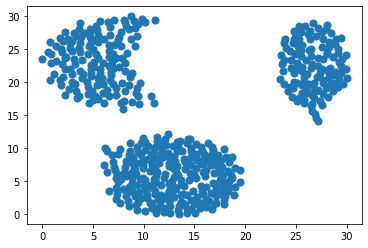

In [92]:
Points = Points_Training
plt.scatter(Points[:, 0], Points[:, 1], s=50)

# Método Cotovelo

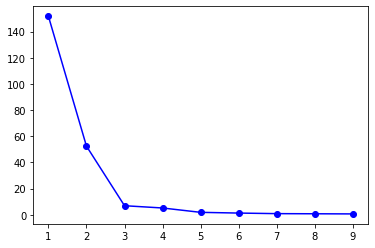

In [93]:
temp_epsilon = []
num_cluster = range(1,10)
for k in num_cluster:
    centers, labels = Kmeans(Points, k)
    # plt.scatter(Points[:, 0], Points[:, 1], c=labels,s=50, cmap='viridis')
    # plt.show()
    for p in range(k):
        n=0
        for x in centers: 
            z=0
            for i in range(len(labels)):
                if labels[i] == p:
                    # z += np.square(Points[i][0] - x[0]) + np.square(Points[i][1] - x[1])
                    z += np.linalg.norm(Points[i] - x)**2
                    n+=1   
    temp_epsilon.append(z/n)


plt.plot(num_cluster,temp_epsilon,"bo-")
plt.show()

# Kmeans no cluster.dat

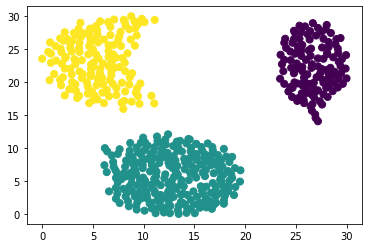

In [94]:
centers, labels = Kmeans(Points, 3)
plt.scatter(Points[:, 0], Points[:, 1], c=labels,s=50, cmap='viridis')

# Teste Kmeans

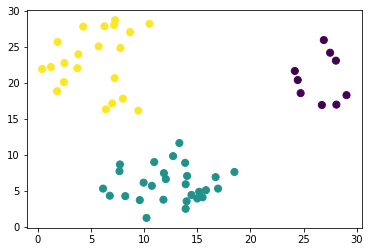

In [95]:
labels_test = aLabel(Points_Test, centers)
plt.scatter(Points_Test[:, 0], Points_Test[:, 1], c=labels_test,s=50, cmap='viridis')

# Função para encontrar pontos vizinhos

In [96]:
def neighbor_points(data, pointId, radius):
    points = []
    for i in range(len(data)):
        if np.linalg.norm(data[i] - data[pointId]) <= radius:
            points.append(i)
    return points

# Implementação DBScan

In [97]:

core = -1
edge = -2

def DBScan(dataSet, radius, minPt):

    
    pointLabel  = [0] * len(dataSet)
    pointCount = []
    corePoint=[]
    nonCore=[]
    
    for i in range(len(dataSet)):
        pointCount.append(neighbor_points(dataSet,i,radius))
    
    for i in range(len(pointCount)):
        if (len(pointCount[i])>=minPt):
            pointLabel[i]=core
            corePoint.append(i)
        else:
            nonCore.append(i)

    for i in nonCore:
        for j in pointCount[i]:
            if j in corePoint:
                pointLabel[i]=edge
                break
            
    cluster = 1
    for i in range(len(pointLabel)):
        q = queue.Queue()
        if (pointLabel[i] == core):
            pointLabel[i] = cluster
            for x in pointCount[i]:
                if(pointLabel[x]==core):
                    q.put(x)
                    pointLabel[x]=cluster
                elif(pointLabel[x]==edge):
                    pointLabel[x]=cluster 
            while not q.empty():
                neighbors = pointCount[q.get()]
                for y in neighbors:
                    if (pointLabel[y]==core):
                        pointLabel[y]=cluster
                        q.put(y)
                    if (pointLabel[y]==edge):
                        pointLabel[y]=cluster            
            cluster+=1
           
    return pointLabel,cluster

# Função para plotar DBScan bonito

In [98]:
def plotRes(data, clusterRes, clusterNum):
    nPoints = len(data)
    scatterColors = ['black', 'green', 'brown', 'red', 'purple', 'orange', 'yellow']
    for i in range(clusterNum):
        if (i==0):
            color='blue'
        else:
            color = scatterColors[i % len(scatterColors)]
        x1 = [];  y1 = []
        for j in range(nPoints):
            if clusterRes[j] == i:
                x1.append(data[j, 0])
                y1.append(data[j, 1])
        plt.scatter(x1, y1, c=color, alpha=1, marker='.')

# Vários DBScan rodando

Set eps = 1, Minpoints = 2


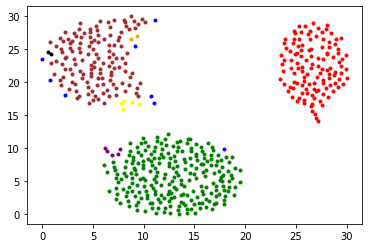

number of cluster found: 7
Counter({1: 239, 2: 133, 3: 121, 0: 8, 4: 5, 6: 5, 5: 2, 7: 2})
number of outliers found: 8

Set eps = 1, Minpoints = 3


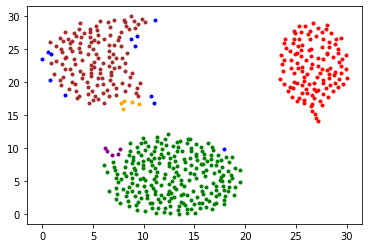

number of cluster found: 5
Counter({1: 239, 2: 133, 3: 121, 0: 12, 4: 5, 5: 5})
number of outliers found: 12

Set eps = 1, Minpoints = 4


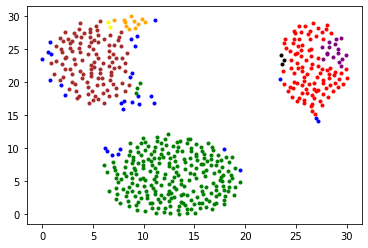

number of cluster found: 8
Counter({1: 238, 2: 112, 3: 99, 0: 31, 4: 16, 5: 11, 7: 3, 8: 3, 6: 2})
number of outliers found: 31

Set eps = 1, Minpoints = 5


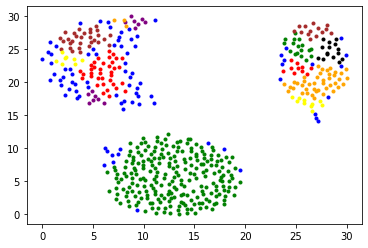

number of cluster found: 13
Counter({1: 234, 0: 82, 5: 42, 3: 36, 2: 30, 8: 17, 7: 15, 9: 14, 6: 10, 10: 10, 13: 8, 4: 7, 11: 7, 12: 3})
number of outliers found: 82

Set eps = 1, Minpoints = 6


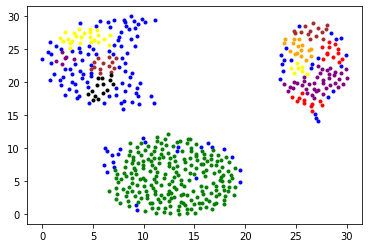

number of cluster found: 14
Counter({1: 216, 0: 136, 4: 40, 6: 24, 9: 14, 2: 13, 10: 12, 3: 11, 5: 11, 7: 8, 13: 7, 14: 6, 8: 6, 11: 6, 12: 5})
number of outliers found: 136

Set eps = 1, Minpoints = 7


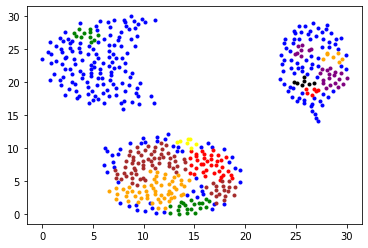

number of cluster found: 12
Counter({0: 263, 2: 59, 5: 55, 3: 36, 1: 20, 9: 18, 11: 18, 8: 11, 4: 8, 12: 7, 7: 7, 6: 7, 10: 6})
number of outliers found: 263

Set eps = 1, Minpoints = 8


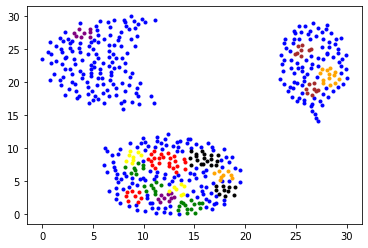

number of cluster found: 15
Counter({0: 357, 3: 23, 7: 18, 1: 14, 12: 13, 14: 10, 11: 9, 5: 8, 15: 8, 9: 8, 2: 8, 4: 8, 6: 8, 10: 8, 8: 8, 13: 7})
number of outliers found: 357

Set eps = 1, Minpoints = 9


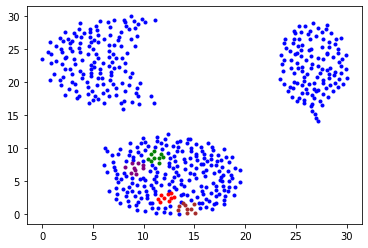

number of cluster found: 4
Counter({0: 479, 2: 9, 4: 9, 1: 9, 3: 9})
number of outliers found: 479

Set eps = 2, Minpoints = 2


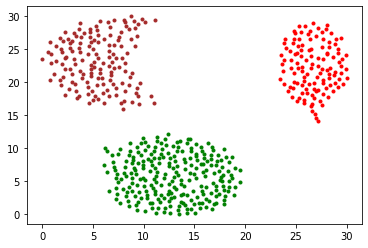

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 2, Minpoints = 3


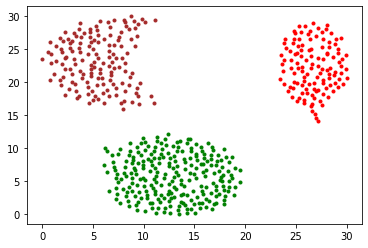

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 2, Minpoints = 4


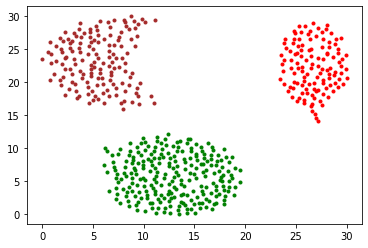

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 2, Minpoints = 5


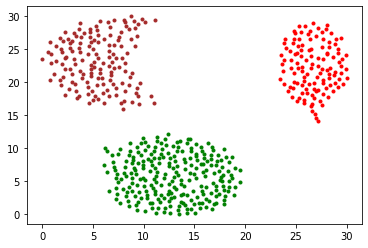

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 2, Minpoints = 6


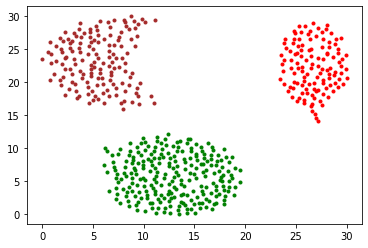

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 2, Minpoints = 7


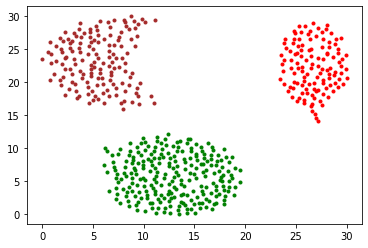

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 2, Minpoints = 8


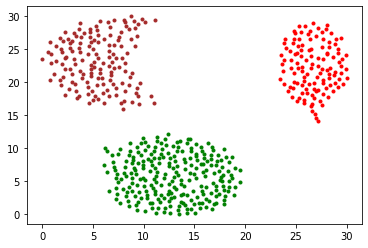

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 2, Minpoints = 9


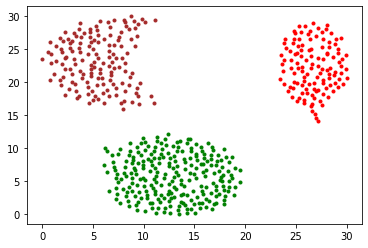

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 3, Minpoints = 2


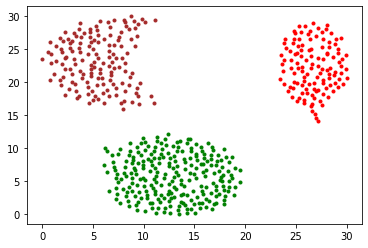

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 3, Minpoints = 3


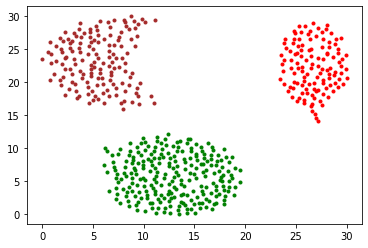

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 3, Minpoints = 4


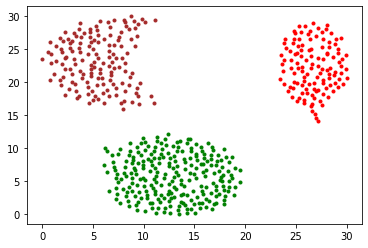

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 3, Minpoints = 5


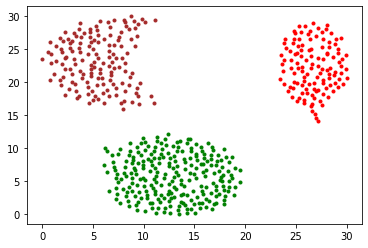

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 3, Minpoints = 6


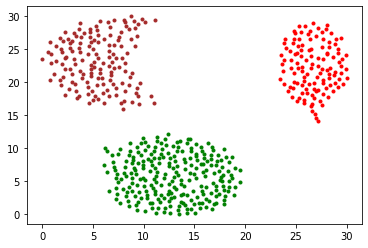

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 3, Minpoints = 7


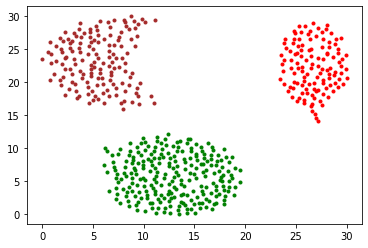

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 3, Minpoints = 8


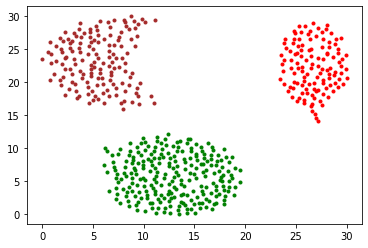

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 3, Minpoints = 9


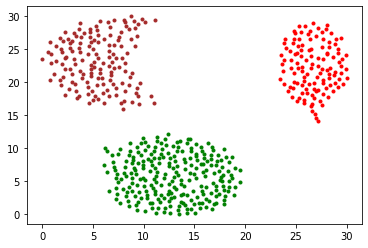

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 4, Minpoints = 2


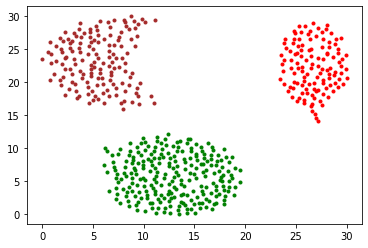

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 4, Minpoints = 3


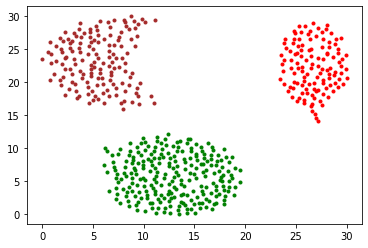

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 4, Minpoints = 4


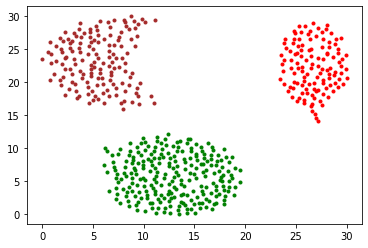

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 4, Minpoints = 5


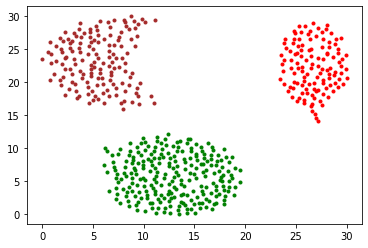

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 4, Minpoints = 6


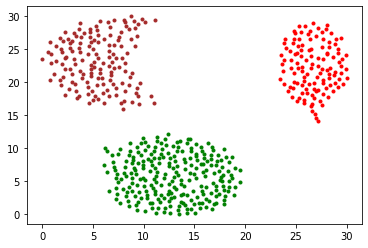

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 4, Minpoints = 7


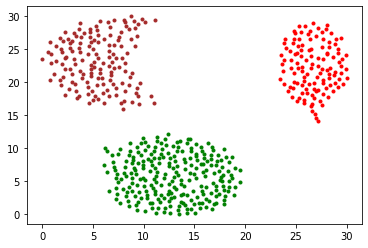

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 4, Minpoints = 8


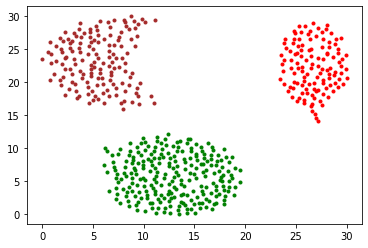

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 4, Minpoints = 9


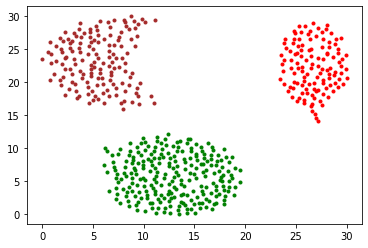

number of cluster found: 3
Counter({1: 245, 2: 149, 3: 121})
number of outliers found: 0

Set eps = 5, Minpoints = 2


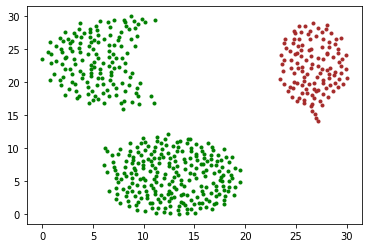

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 5, Minpoints = 3


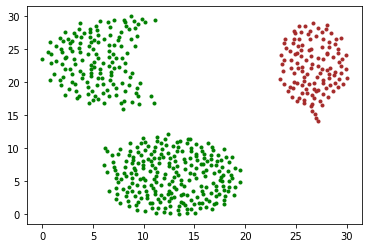

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 5, Minpoints = 4


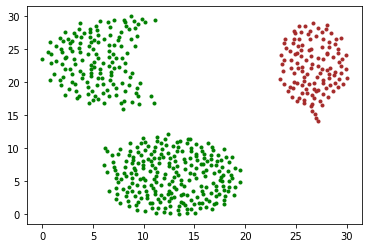

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 5, Minpoints = 5


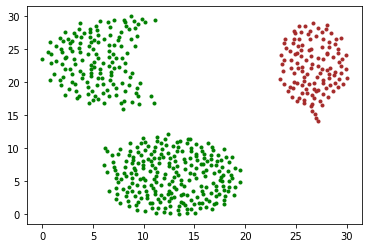

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 5, Minpoints = 6


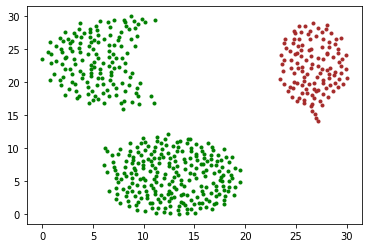

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 5, Minpoints = 7


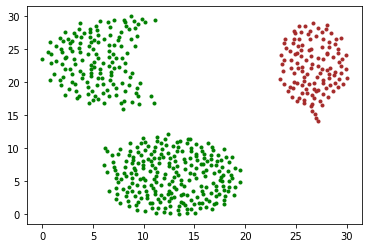

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 5, Minpoints = 8


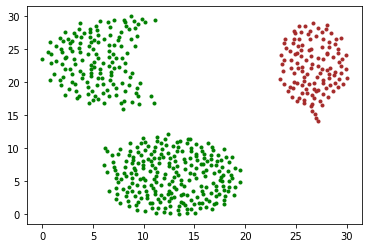

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 5, Minpoints = 9


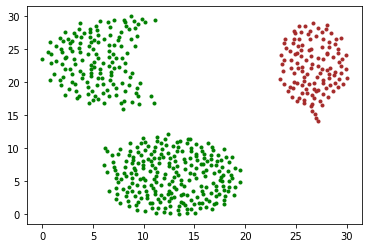

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 6, Minpoints = 2


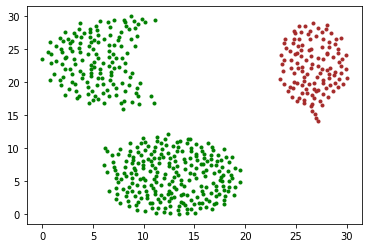

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 6, Minpoints = 3


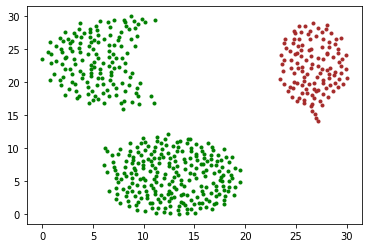

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 6, Minpoints = 4


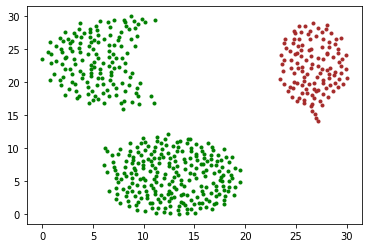

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 6, Minpoints = 5


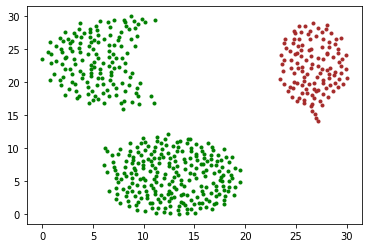

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 6, Minpoints = 6


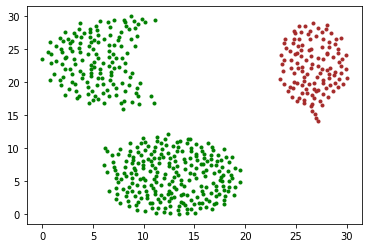

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 6, Minpoints = 7


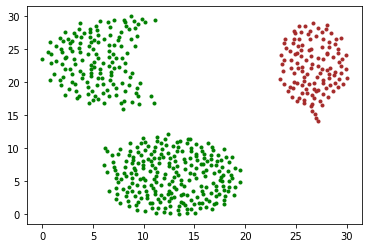

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 6, Minpoints = 8


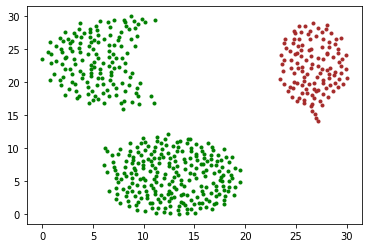

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 6, Minpoints = 9


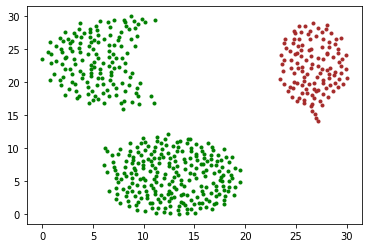

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 7, Minpoints = 2


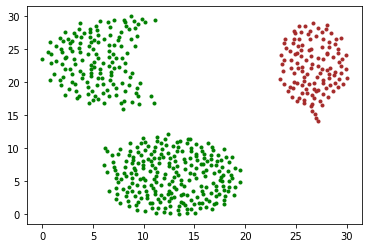

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 7, Minpoints = 3


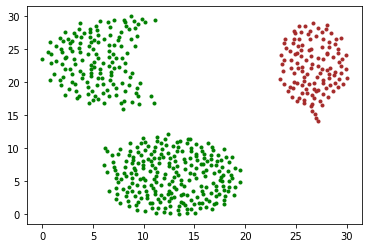

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 7, Minpoints = 4


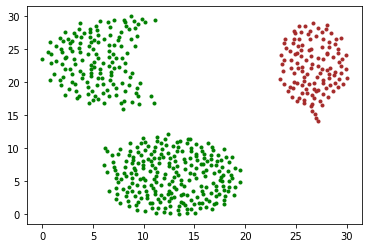

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 7, Minpoints = 5


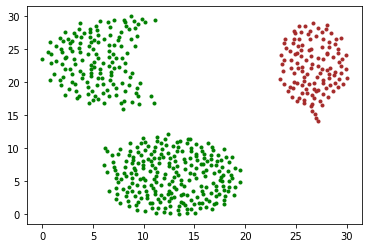

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 7, Minpoints = 6


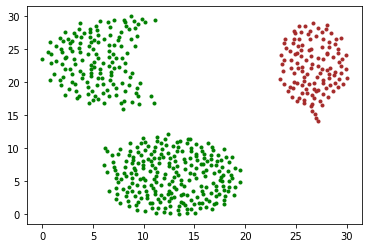

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 7, Minpoints = 7


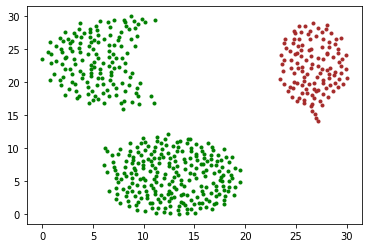

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 7, Minpoints = 8


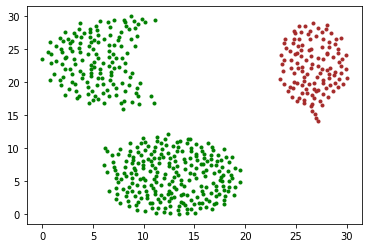

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 7, Minpoints = 9


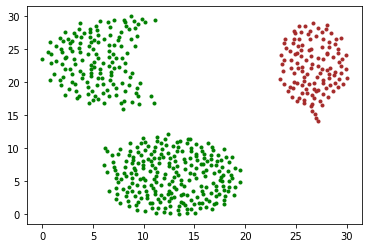

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 8, Minpoints = 2


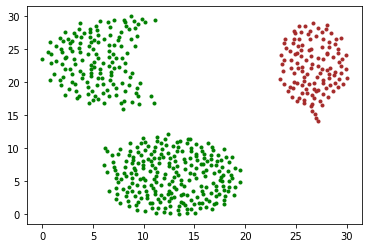

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 8, Minpoints = 3


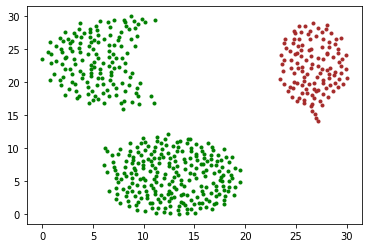

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 8, Minpoints = 4


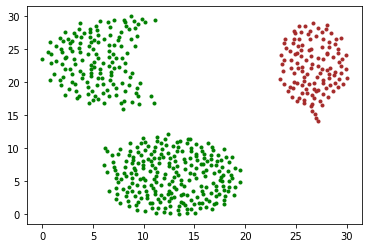

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 8, Minpoints = 5


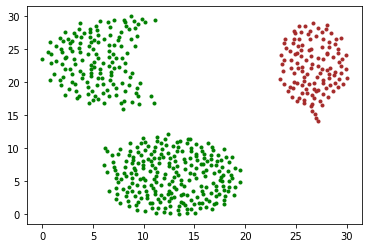

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 8, Minpoints = 6


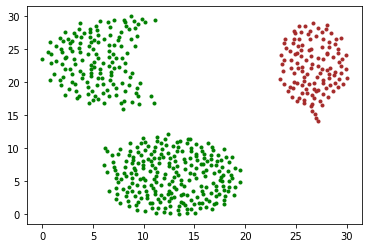

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 8, Minpoints = 7


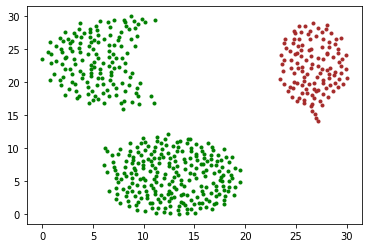

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 8, Minpoints = 8


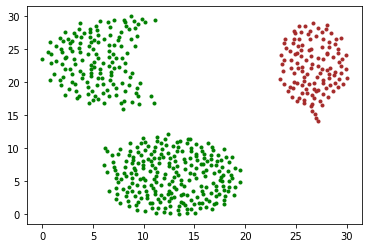

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 8, Minpoints = 9


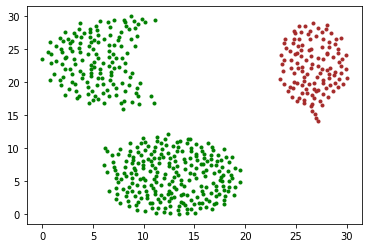

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 9, Minpoints = 2


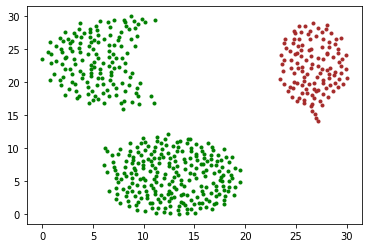

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 9, Minpoints = 3


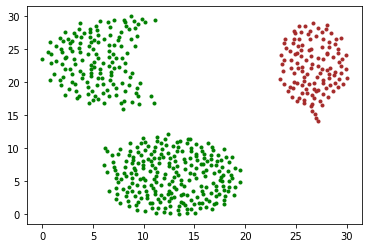

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 9, Minpoints = 4


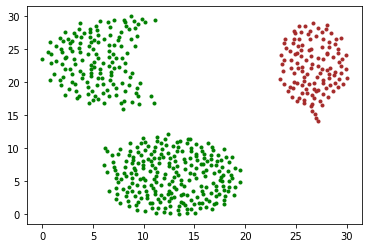

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 9, Minpoints = 5


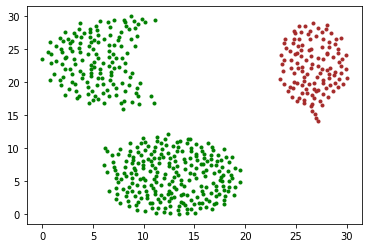

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 9, Minpoints = 6


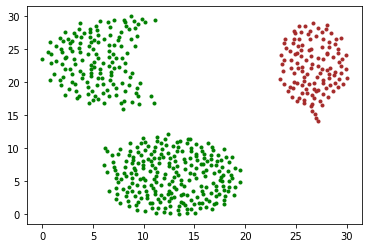

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 9, Minpoints = 7


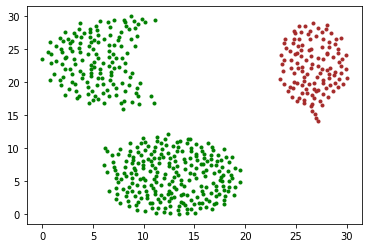

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 9, Minpoints = 8


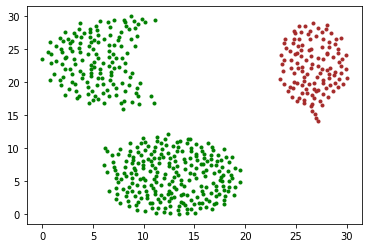

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0

Set eps = 9, Minpoints = 9


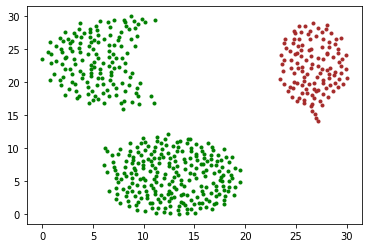

number of cluster found: 2
Counter({1: 394, 2: 121})
number of outliers found: 0



In [99]:
epss = 10
minptss = 10
Points = Points_Training

Leps = []
Lminpts = []
Lcluster = []

for eps in range(1,epss):
    for minpts in range(2,minptss):
        print('Set eps = ' +str(eps)+ ', Minpoints = '+str(minpts))
        pointlabel,cl = DBScan(Points,eps,minpts)
        plotRes(Points, pointlabel, cl)
        plt.show()
        print('number of cluster found: ' + str(cl-1))
        counter=collections.Counter(pointlabel)
        print(counter)
        outliers  = pointlabel.count(0)
        print('number of outliers found: '+str(outliers) +'\n')
        Leps.append(eps)
        Lminpts.append(minpts)
        Lcluster.append(cl-1)



# Escolhendo Epslon e Pontos mínimos para DBScan

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(Leps, Lminpts, Lcluster)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

# DBScan com epslon e pontos escolhido

pointlabel,cl = DBScan(Points,2,2)
plotRes(Points, pointlabel, cl)
plt.show()

# Teste DBScan


labels_points_test = []

for i in range(len(Points_Test)):
    for j in range(len(Points)):
        if np.linalg.norm(Points_Test[i] - Points[j]) <= 2:
            labels_points_test.append(pointlabel[j])
            break

plotRes(Points_Test, labels_points_test, cl)
plt.show()
            

# Validando método de escolher epson e minpts

from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=5,
                       cluster_std=5,center_box=(0, 100), random_state=3)
plt.scatter(X[:, 0], X[:, 1], s=50)

epss = 10
minptss = 10

Leps = []
Lminpts = []
Lcluster = []

for eps in range(2,epss):
    for minpts in range(2,minptss):
        aux = [0,0,0]
        print('Set eps = ' +str(eps)+ ', Minpoints = '+str(minpts))
        pointlabel,cl = DBScan(X,eps,minpts)
        plotRes(X, pointlabel, cl)
        plt.show()
        print('number of cluster found: ' + str(cl-1))
        counter=collections.Counter(pointlabel)
        print(counter)
        outliers  = pointlabel.count(0)
        print('number of outliers found: '+str(outliers) +'\n')
        if(cl-1 < 12):
            Leps.append(eps)
            Lminpts.append(minpts)
            Lcluster.append(cl-1)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(Leps, Lminpts, Lcluster)
ax.plot(Leps[16:19], Lminpts[16:19], Lcluster[16:19],"r-")
ax.plot(Leps[24:27], Lminpts[24:27], Lcluster[24:27],"r-")
plt.title("simple 3D scatter plot")

print(Leps[16:19], Lminpts[16:19], Lcluster[16:19])
print(Leps[24:27], Lminpts[24:27], Lcluster[24:27])
 
# show plot
plt.show()

# Agora com o dataset adiquirido

In [100]:
import csv

with open('countries_of_the_world.csv') as arq:
    
    reader = csv.reader(arq, delimiter=',')

    arq_in = [[x.replace(' ', '') for x in line] for line in reader]
    
    saida = []
    count = 0

    for line in arq_in:
            
        
        if count == 0:
            saida.append(line)
        else:
            if not line.__contains__(''):

                ini = line[:2]

                fim = line[2:]

                aux = [float(x.replace(',','.')) for x in fim]

                lin = ini + aux

                saida.append(lin)
        count+=1    
    
        
    
with open('countries_of_the_world_trimmed.csv', mode='w', newline='') as arq_out:

    writer = csv.writer(arq_out, delimiter=',')
    
    writer.writerows(saida)

In [101]:
with open('countries_of_the_world_trimmed.csv') as arq_in:
    
    count = 0
    reader = csv.reader(arq_in, delimiter=',')

    ini = []
    fim = []

    for line in reader:  

        if count != 0:
            ini.append(line[:2])
            fim.append(line[2:])


        count += 1


    xy = np.array([[float(d) for d in lin] for lin in fim])

In [102]:
xy = MinMax(xy)

In [103]:
print(xy)

[[ 0.70877761  2.01675521  0.08565496 ... 14.82444733  7.1395881
  10.69506726]
 [ 0.08146772  0.08945747  0.22767162 ...  9.05071521  5.35469108
  17.38789238]
 [ 0.75154361  7.41859121  0.02224804 ...  3.94018205 19.49656751
   7.93721973]
 ...
 [ 0.48957443  1.64444143  0.07193533 ...  5.26657997 15.10297483
  11.132287  ]
 [ 0.26230321  2.34416583  0.02502905 ...  8.58257477  8.85583524
  14.36098655]
 [ 0.27907986  1.21649705  0.0546931  ...  6.98309493  7.24256293
  17.38789238]]


In [104]:
p90 = int(len(xy)* 90/100)

rng = np.random.RandomState(15)
i = rng.permutation(xy.shape[0])

Points_Training =xy[i[:p90]]
Points_Test=xy[i[p90:len(xy)]]

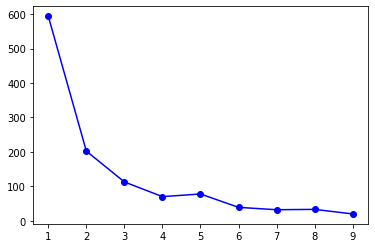

In [105]:
Points = Points_Training

temp_epsilon = []
num_cluster = range(1,10)
for k in num_cluster:
    centers, labels = Kmeans(Points, k)
    # plt.scatter(Points[:, 0], Points[:, 1], c=labels,s=50, cmap='viridis')
    # plt.show()
    for p in range(k):
        n=0
        for x in centers: 
            z=0
            for i in range(len(labels)):
                if labels[i] == p:
                    # z += np.square(Points[i][0] - x[0]) + np.square(Points[i][1] - x[1])
                    z += np.linalg.norm(Points[i] - x)**2
                    n+=1   
    temp_epsilon.append(z/n)


plt.plot(num_cluster,temp_epsilon,"bo-")
plt.show()

In [106]:
centers, labels = Kmeans(Points, 4)

In [107]:
print(centers)

[[4.70710417e-01 1.72538950e+00 1.20679142e-01 1.61502002e-01
  1.38311010e+01 6.73902227e+00 4.64343164e+00 2.40461165e+01
  4.21415312e+00 2.39328074e+00 1.36138344e+00 2.67694615e+01
  6.55555556e+00 1.17500000e+01 5.88047323e+00 4.75856090e+00
  1.10518688e+01 1.55388640e+01]
 [5.28800338e-01 1.63217436e+00 1.38153319e-01 1.30562649e-02
  1.45839188e+01 1.64955470e+01 7.10818057e-01 1.40150223e+01
  3.57450344e-01 6.04106925e+00 1.72578829e+00 2.31050069e+01
  8.78378378e+00 2.14148126e+01 1.43967128e+01 1.41760096e+01
  7.09876925e+00 1.13004484e+01]
 [1.20742428e+00 9.37997710e-01 4.23695961e-01 1.36836632e+00
  1.20334331e+01 3.97788056e+00 4.15305874e+00 2.64728597e+01
  6.22400211e+00 1.26807277e+01 6.95020053e+00 1.30826186e+01
  1.56060606e+01 7.03792064e+00 6.36962379e+00 5.23584348e+00
  9.08258789e+00 1.70556461e+01]
 [4.57154084e-01 1.66106959e+00 1.51659091e+00 1.02339155e+00
  1.57457435e+01 1.04304018e+00 1.70596806e+01 2.88175390e+01
  1.64116391e+01 7.03667406e+00 1

In [108]:
print(labels)

[2 0 1 1 0 3 3 3 0 3 2 3 1 0 3 0 3 3 3 0 3 0 1 1 2 1 3 3 1 0 0 0 0 2 2 3 1
 1 2 1 1 2 3 2 1 1 1 0 3 0 2 3 3 1 2 2 3 1 2 3 0 1 0 1 3 1 1 3 2 1 3 1 0 3
 0 1 3 1 0 1 3 0 0 2 3 3 3 0 2 0 3 1 0 3 2 0 0 2 0 3 2 1 3 1 2 0 0 2 2 3 0
 2 1 0 3 0 0 1 0 0 0 3 2 2 0 3 2 0 2 2 3 1 1 1 0 3 2 3 2 1 3 3 3 3 1 0 0 0
 0 0 0 1 2 3 1 2 0 2 3 2 3]


In [109]:
centers, labels = Kmeans(Points, 3)

In [110]:
print(centers)

[[4.05491709e-01 1.16195891e+00 2.53406382e-01 1.11047570e+00
  1.31172421e+01 4.37373851e+00 5.03978206e+00 2.55277169e+01
  5.71019481e+00 4.10063311e+00 4.53619149e+00 2.28477528e+01
  8.62903226e+00 9.41120121e+00 4.25657732e+00 4.85695709e+00
  9.22344431e+00 1.72381745e+01]
 [1.04498292e+00 1.68248019e+00 1.69251199e-01 1.34883307e-02
  1.44622588e+01 1.56065353e+01 8.83042895e-01 1.53322209e+01
  4.69759412e-01 6.30564724e+00 1.50914011e+00 2.30175679e+01
  8.54166667e+00 2.03762373e+01 1.36990029e+01 1.22317945e+01
  8.39316362e+00 1.17075392e+01]
 [5.16117733e-01 1.81560006e+00 1.38141431e+00 5.97761536e-01
  1.52147960e+01 1.42266012e+00 1.57293802e+01 2.90426899e+01
  1.54237155e+01 1.01266254e+01 1.16757978e+00 1.97085734e+01
  1.76470588e+01 3.23732532e+00 6.97186888e+00 1.77235524e+00
  7.99838471e+00 2.11059087e+01]]


In [111]:
print(labels)

[2 0 1 1 0 2 0 2 0 2 0 2 1 0 2 0 0 2 2 0 0 0 1 1 0 1 2 2 1 0 0 0 1 2 0 2 1
 1 0 1 1 0 2 0 1 1 1 0 2 0 0 0 2 1 0 1 0 1 0 2 0 1 0 1 2 1 1 2 2 1 0 1 0 2
 0 1 2 1 0 1 2 0 1 2 2 2 2 1 0 1 2 1 0 2 2 0 0 0 1 0 0 1 2 1 0 0 0 0 2 2 0
 0 1 0 2 0 0 1 0 0 0 2 2 0 0 2 2 1 0 2 2 1 1 1 0 2 2 2 2 1 2 2 2 2 1 1 1 1
 0 0 0 1 0 2 1 2 0 1 2 0 2]


In [122]:
for eps in range(1,epss):
    for minpts in range(1,minptss):
        print('Set eps = ' +str(eps)+ ', Minpoints = '+str(minpts))
        pointlabel,cl = DBScan(Points,eps,minpts)
        print('number of cluster found: ' + str(cl-1))
        counter=collections.Counter(pointlabel)
        print(counter)
        outliers  = pointlabel.count(0)
        print('number of outliers found: '+str(outliers) +'\n')


Set eps = 1, Minpoints = 1
number of cluster found: 161
Counter({1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131

In [113]:
print(cl)

1
